# Logistic Regression vs LOOT

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import scatter

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.autograd.functional import hessian
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Set up before training

In [66]:
train_dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transforms.ToTensor(), download = True)
test_dataset = torchvision.datasets.MNIST(root="./data", train=False, transform=transforms.ToTensor(), download = True)

In [72]:
input_size = 784
num_classes = 10
num_epochs = 15
batch_size = 100
learning_rate = 0.001

training_size = 60000
testing_size = 10000

np.random.seed(35)
#training_selector = np.random.choice(range(60000), replace = False, size = training_size)
#testing_selector = np.random.choice(range(10000), replace = False, size = testing_size)
training_selector = np.arange(60000)
testing_selector = np.arange(10000)

class Alpha_Train_Dataset(Dataset):
  def __init__(self):
      
      self.x = train_dataset.data[training_selector].float()
      self.y = train_dataset.targets[training_selector]
      
      #self.n_samples = int(train_dataset.data.shape[0]*alpha)
      self.n_samples = len(training_selector)

  def __getitem__(self, index):
      return self.x[index], self.y[index]
  def __len__(self):
      return self.n_samples

class Alpha_Test_Dataset(Dataset):
  def __init__(self):
      
      self.x = test_dataset.data[testing_selector].float()#[random_selector].float()
      self.y = test_dataset.targets[testing_selector]#[random_selector]
      
      self.n_samples = len(testing_selector)

  def __getitem__(self, index):
      return self.x[index], self.y[index]
  def __len__(self):
      return self.n_samples

class NeuralNet(nn.Module):
  def __init__(self, input_size, num_classes):
    super(NeuralNet, self).__init__()
    self.l1 = nn.Linear(input_size, num_classes, bias = False)
  
  def forward(self, x):
    out = self.l1(x)
    return out

## Training

In [73]:
alpha_train_dataset = Alpha_Train_Dataset()
train_loader = torch.utils.data.DataLoader(dataset=alpha_train_dataset, batch_size=batch_size, shuffle=True)

model = NeuralNet(input_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # 100, 1, 28, 28
        #images = images.reshape(-1, 28*28).to(device) # can change -1 to 100
        images = ((images.reshape(-1, 28*28)/255- 0.1307)/0.3081).to(device)
        labels = labels.to(device)

        # forward
        outputs = model(images)
        loss = criterion(outputs, labels)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

alpha_test_dataset = Alpha_Test_Dataset()
test_loader = torch.utils.data.DataLoader(dataset=alpha_test_dataset, batch_size=1, shuffle=False)

misclassified_lst = []

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    counter = 0
    for images, labels in test_loader:
        # 把一个batch reshape 成一个 100 by 784 的 vector 来做prediction
        #images = images.reshape(-1, 28*28).to(device)
        images = ((images.reshape(-1, 28*28)/255- 0.1307)/0.3081).to(device)
        labels = labels.to(device)
        output = model(images)
        # value, index
        _, predictions = torch.max(output, 1)
        n_samples += labels.shape[0]
        n_correct += (predictions == labels).sum().item()

        if (predictions == labels).sum().item() == 0:
            misclassified_lst.append(counter)
        counter += 1

    acc = 100 * n_correct/n_samples

In [74]:
acc

90.73

## Calculate Inverse Hessian

In [87]:
w = torch.cat(tuple([_.view(-1) for _ in model.parameters()])).detach()

In [88]:
def logistics_regression_loss_all(w):
    
    #w = w.clone().detach().requires_grad_(True)

    train_loader = torch.utils.data.DataLoader(dataset=alpha_train_dataset, batch_size=training_size, shuffle=False)
    examples = iter(train_loader)
    images, labels = examples.next()

    images = ((images.reshape(-1, 28*28)/255- 0.1307)/0.3081).to(device)

    out1 = F.linear(images, w.reshape(10,784))

    loss = criterion(out1, labels.to(device))*training_size

    return loss

In [89]:
with torch.no_grad():
   Hessian = hessian(logistics_regression_loss_all, w)/training_size

In [90]:
damping_matrix = torch.tensor(np.diag(np.full(Hessian.shape[0],0.001),0)).to(device)
damping_hessian = Hessian + damping_matrix
inv_hessian = torch.linalg.inv(damping_hessian)

## Calculate gradient at single point

In [91]:
def loss_grad_at_point(w, train_point):
    # w should be torch.cat(tuple([_.view(-1) for _ in model.parameters()]))
    # train_point should be alpha_train_dataset[0], a tuple of image and label

    w = w.clone().detach().requires_grad_(True)

    images = ((train_point[0].reshape(-1, 28*28)/255- 0.1307)/0.3081).to(device)

    out1 = F.linear(images, w.reshape(10,784))

    loss = criterion(out1, torch.tensor([train_point[1]]).to(device))
    loss.backward()

    return w.grad

## Define a test point

In [85]:
misclassified_lst[5]

80

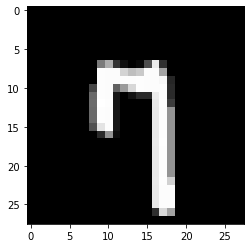

In [94]:
test_point = (test_dataset.data[80].float(), test_dataset.targets[80])
plt.imshow(alpha_test_dataset[80][0], cmap = "gray")

## Calculate IF scores

In [93]:
def calculate_if(train_point, test_point, inv_Hessian):
    # test point should be alpha_test_dataset[10]

    test_loss = loss_grad_at_point(w, test_point)#.to("cpu").numpy()

    train_loss = loss_grad_at_point(w, train_point)#.to("cpu").numpy()

    if_score = -torch.matmul(torch.matmul(test_loss.t(), inv_Hessian), train_loss)

    return if_score

In [95]:
test_point = (test_dataset.data[80].float(), test_dataset.targets[80])
if_score_list = []
for i in range(training_size):
    train_point = (train_dataset.data[i].float(), train_dataset.targets[i])
    if_score = calculate_if(train_point, test_point, inv_hessian.float())
    if_score_list.append(if_score)
    if (i+1) % 10000 == 0:
        print(f"{i+1}/60000 complete")

10000/60000 complete
20000/60000 complete
30000/60000 complete
40000/60000 complete
50000/60000 complete
60000/60000 complete


## Result

In [96]:
if_score_series = pd.Series(torch.tensor(if_score_list).to("cpu"))
if_score_series_sorted = if_score_series.sort_values(ascending = False)

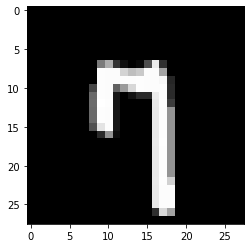

In [97]:
test_point = (test_dataset.data[80].float(), test_dataset.targets[80])
plt.imshow(test_dataset.data[80], cmap = "gray")

Text(0.5, 1.0, '7')

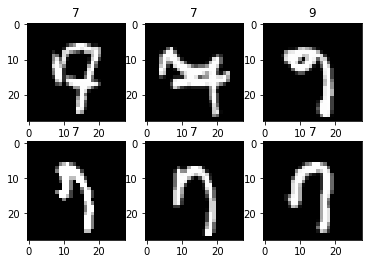

In [98]:
fig, axs = plt.subplots(2, 3)
axs[0][0].imshow(train_dataset.data[if_score_series_sorted.index[0]], cmap = "gray")
axs[0][1].imshow(train_dataset.data[if_score_series_sorted.index[1]], cmap = "gray")
axs[0][2].imshow(train_dataset.data[if_score_series_sorted.index[2]], cmap = "gray")
axs[1][0].imshow(train_dataset.data[if_score_series_sorted.index[-1]], cmap = "gray")
axs[1][1].imshow(train_dataset.data[if_score_series_sorted.index[-2]], cmap = "gray")
axs[1][2].imshow(train_dataset.data[if_score_series_sorted.index[-3]], cmap = "gray")
#alpha_train_dataset[if_score_series_sorted.index[-1]][0]

axs[0, 0].set_title(str(train_dataset.targets[if_score_series_sorted.index[0]].item()))
axs[0, 1].set_title(str(train_dataset.targets[if_score_series_sorted.index[1]].item()))
axs[0, 2].set_title(str(train_dataset.targets[if_score_series_sorted.index[2]].item()))
axs[1, 0].set_title(str(train_dataset.targets[if_score_series_sorted.index[-1]].item()))
axs[1, 1].set_title(str(train_dataset.targets[if_score_series_sorted.index[-2]].item()))
axs[1, 2].set_title(str(train_dataset.targets[if_score_series_sorted.index[-3]].item()))

## Compare with leave one out training

In [99]:
idx_to_remove = np.array(if_score_series_sorted.apply(lambda x: abs(x)).sort_values(ascending = False).index[:50])

In [100]:
diff_in_loss_by_if = np.array(if_score_series[idx_to_remove]/(-60000))

### Define dataset and find original test loss

In [101]:
class One_Out_Train_Dataset(Dataset):
  def __init__(self, training_selector):
      
      self.x = train_dataset.data[training_selector].float()
      self.y = train_dataset.targets[training_selector]
      
      #self.n_samples = int(train_dataset.data.shape[0]*alpha)
      self.n_samples = len(training_selector)

  def __getitem__(self, index):
      return self.x[index], self.y[index]
  def __len__(self):
      return self.n_samples

class Alpha_Test_Dataset(Dataset):
  def __init__(self):
      
      self.x = test_dataset.data[testing_selector].float()#[random_selector].float()
      self.y = test_dataset.targets[testing_selector]#[random_selector]
      
      self.n_samples = len(testing_selector)

  def __getitem__(self, index):
      return self.x[index], self.y[index]
  def __len__(self):
      return self.n_samples

In [102]:
test_point = (test_dataset.data[80].float(), test_dataset.targets[80])
test_image = ((test_point[0].reshape(-1, 28*28)/255- 0.1307)/0.3081).to(device)
test_label = torch.tensor([test_point[1]]).to(device)

In [103]:
def loss_at_point(w, train_point):
    # w should be torch.cat(tuple([_.view(-1) for _ in model.parameters()]))
    # train_point should be alpha_train_dataset[0], a tuple of image and label

    images = ((train_point[0].reshape(-1, 28*28)/255- 0.1307)/0.3081).to(device)

    out1 = F.linear(images, w.reshape(10,784))

    loss = criterion(out1, torch.tensor([train_point[1]]).to(device))

    return loss

In [104]:
original_test_loss = loss_at_point(w, test_point).item()

### Calculate loss without one training point

In [106]:
change_in_loss_lst = []
counter = 0
for idx in idx_to_remove:
    training_selector = np.concatenate((np.arange(0,idx), np.arange(idx+1,60000)))

    alpha_train_dataset = One_Out_Train_Dataset(training_selector)

    train_loader = torch.utils.data.DataLoader(dataset=alpha_train_dataset, batch_size=batch_size, shuffle=True)

    model = NeuralNet(input_size, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            # 100, 1, 28, 28
            images = ((images.reshape(-1, 28*28)/255- 0.1307)/0.3081).to(device)
            labels = labels.to(device)

            # forward
            outputs = model(images)
            loss = criterion(outputs, labels)

            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    with torch.no_grad():
        test_output = model(test_image)
        test_loss = criterion(test_output, test_label)
        change_in_loss_lst.append(test_loss.item() - original_test_loss)
        counter = counter + 1
        print(f"{counter}/50 complete")

1/50 complete
2/50 complete
3/50 complete
4/50 complete
5/50 complete
6/50 complete
7/50 complete
8/50 complete
9/50 complete
10/50 complete
11/50 complete
12/50 complete
13/50 complete
14/50 complete
15/50 complete
16/50 complete
17/50 complete
18/50 complete
19/50 complete
20/50 complete
21/50 complete
22/50 complete
23/50 complete
24/50 complete
25/50 complete
26/50 complete
27/50 complete
28/50 complete
29/50 complete
30/50 complete
31/50 complete
32/50 complete
33/50 complete
34/50 complete
35/50 complete
36/50 complete
37/50 complete
38/50 complete
39/50 complete
40/50 complete
41/50 complete
42/50 complete
43/50 complete
44/50 complete
45/50 complete
46/50 complete
47/50 complete
48/50 complete
49/50 complete
50/50 complete


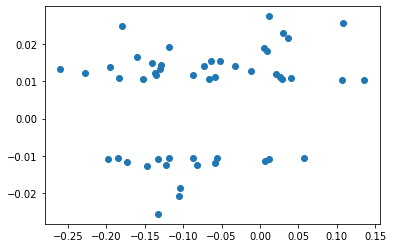

In [107]:
change_in_loss_array = np.array(change_in_loss_lst)
scatter(change_in_loss_array, diff_in_loss_by_if)